In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
# from stop_words import get_stop_words
# import Stemmer
# import pymorphy2
# from segtok import segmenter
import re
from functools import partial
import pickle
# from gensim import corpora, models
# from gensim.models import word2vec
# import xgboost as xgb 
%matplotlib inline

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.utils import np_utils
# from keras.layers.advanced_activations import PReLU
# from keras.optimizers import SGD

# Loading data

In [10]:
data = pd.read_csv('data/comments_vrn.csv.gz')

In [11]:
data.shape

(185612, 6)

In [12]:
data.is_gum.value_counts()

0.0    98373
1.0    87239
Name: is_gum, dtype: int64

In [13]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,9048238,Вжух даже здесь,0.0,20,1,2
1,9048238,И пишите аккуратнее 😞,0.0,12,3,2
2,9048238,Это #имбрина 😏,0.0,21,0,2


## Examples of two classes

In [14]:
data[data.is_gum == False].text.sample(10).values

array(['Дубай', '[id67100252|Евгений], Ага))',
       '[id16867860|Дмитрий], в каком плане "у входа"? Там плохой контингент? Или я дресскод и фейсконтроль не пройду?',
       'только за футболку Я РУССКИЙ тебя сразу в фашисты запишут',
       'Быдло реклама, радует нас ежедневно.', 'из окна работы видно',
       '[id40199394|Дмитрий], 19 мне',
       '[id158384001|Александр], что там доказывать-то? Приехали менты, зафиксировали факт ДТП, объявили формально в розыск (по факту без номеров никакого розыска не будет)\nЧерез неделю у ТС на руках номера машины, он звонит в отдел, виновника вызывают на дознание, осматривают машину, сравнивают повреждения\nЕсли тот уже успел покрасить машину и говорит я не я корова не моя... ну ради Бога, если так охота тянуть время...\nТопикстартер идёт с видеозаписью в суд, судья определяет виновника, а дальше каждый идет своей дорогой: один в страховую виновника, другой в суд, который определит: лишение прав или 15 суток.',
       'зачем пизделовку устроили

In [15]:
data[data.is_gum == True].text.sample(10).values

array(['89601384143', 'Нет... надеюсь, хоть это будет норма)',
       '[id83103629|Александр], Военным, многодетным да',
       '[id33102527|Надежда], вот именно по-моему мнению, бомж - человек. Я сказал, что те же самые автор с мужем и слова бы не сказали, если бы это увидели (хотя сомневаюсь, что бомж начнет кидаться на охранников, он хоть и бомж, но не дурак и силы расценивает). Вы оправдываете во всем, так и в убийстве иногда можно оправдать. Насчет охранников. Это вы когда бухие в клубе шатаетесь, вам кажется, что все вам навалять хотят. Нормальные там люди работают, они за это деньги получают и просто так работу терять не хотят. Подраться у них каждый день есть возможность на тренировке. \nПо поводу мужского пола. Есть девушки/женщины/дамы, а есть бабы. Первых трогать нельзя, а если бы вторых почаще на место ставили, то жили бы мы лучше. Хватит прикрываться постоянно тем, какого вы пола. Вести себя нужно как человек, неважно, мужчина вы или женщина. И тогда получать не придется.'

# Preprocessing

## Words count

In [16]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [17]:
lenghts_word.mean(), np.median(lenghts_word)

(11.451069973924099, 7.0)

In [18]:
comments = data[(lenghts_word < 50) & (lenghts_word > 4)]
comments.shape

(114275, 6)

## Links

In [19]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.54% of comments contain links


In [20]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True
                for c in comments.text.values] 

In [21]:
comments = comments[without_link]

In [22]:
comments.shape

(113709, 6)

# Droping outliers

In [23]:
from sklearn.ensemble import IsolationForest

In [24]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2), analyzer='word', max_df=0.6)
X = vectorizer.fit_transform([' '.join(t.split()[:5]) for t in comments.text.values])
y = comments.is_gum.values
# y = comments.sex.values

In [17]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(3, 3), analyzer='char')
X = vectorizer.fit_transform([' '.join(t.split()[:4]) for t in comments.text.values])
y = comments.is_gum.values
# y = comments.sex.values

In [18]:
forest = IsolationForest(200, contamination=0.01, n_jobs=-1)
forest.fit(X)
X_pred = forest.predict(X)
comments['len'] = [len(t) for t in comments.text.values]
comments['outlier'] = X_pred

In [19]:
comments[comments.outlier == -1].head(10).text.values

array([ '[id103687699|Наталья], ясно, полетели какашки. Счастливо кувыркаться в оных, я пошел...',
       '[id50519280|Александр], может, потому что на универе черте-когда стояла линия оптической связи с другим корпусом? В 90-х точно стояла...',
       '[id2761885|Ростислав], считыватели поставить не долго.',
       '[id137476101|Алиса], снижение скорости поможет КАК РАЗ в случае стада тупых баранов: ты его сбиваешь, а он не дохнет. В случае, когда пешеход не лезет на дорогу под колеса - его и не собьют, вне зависимости от скорости :) Другое дело, что и тут море тонкостей...',
       '[id258674171|Саша], окружная дорога предназначена для разгрузки города. Так? Плата за проезд нескольких километров (я, например, постоянно проезжаю участок от ростовской до тамбовской) вытесняет движение на объездные дороги. Разумно, а?',
       '[id10072765|Александр], в вопросах употребления алкоголя? Да хоть 100 порций. И вообще, абсолютных трезвенников во все времена было и есть - крохи. Как среди ген

In [20]:
comments.groupby('outlier').mean()

,from_id,is_gum,hour,likes,sex,len
outlier,,,,,,
-1,9.490806e+07,0.463093,12.731986,0.642355,1.681019,110.748682
1,9.171661e+07,0.462259,12.731432,1.072123,1.701788,88.355234


## Emoji

In [25]:
comments_list = comments.text.values

In [26]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [27]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [28]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [29]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

#### If not done before

In [26]:
len(comments_list)

113709

In [27]:
# %time emoji_from_comments_rep = list(map(get_emoji, comments_list))

In [ ]:
with open('emoji_from_comments_rep_vrn.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [30]:
with open('emoji_from_comments_rep_vrn.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))
len(comments_list), len(emoji_from_comments_rep)

(113709, 113709)

In [31]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [32]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [33]:
print((em_proportion_rep > 0.2).sum())
comments_list[em_proportion_rep > 0.2][:10]

158


array(['👍👍👍👍👍👍клааас❗❗❗❗ эта елка будееет самой красивой😂😂😂😂',
       '😂😂😂😂👍👍👍н ну это ж люди....\n😂😂😂блин а когда новый год???😂',
       '😂😂😂😂😂😂вот бы меня на купюру не плохооо было б😂😂😂',
       'И здесь хорошо и там хорошо....👍👍👍👍👍👍👍👍👍',
       'Да что вы... Кому что нравится 😍😍😍😍👍👍👍👍👍👍👍👍',
       'А мне нравится можно вообще не работать 😂😂😂😂😂👍👍👍👍👍👍',
       '😍😍😍😍😍😍и тишина и спокойствие 👍👍👍👍👍',
       'Кому как но Воронеж это воронеж любим и будем любить 😍😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍',
       'А я отправлю :одумайся не глупи замуж не выходи 😂😂😂😂😂😂👍👍👍👍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻'], dtype=object)

### Without repetition

In [34]:
print((em_proportion_no_rep > 0.07).sum())
comments_list[em_proportion_no_rep > 0.07][:10]

285


array(['Главное чтоб не поздно 😂😂😂👍', '😂😂😂это я с Перми возвращаюсь 😍😍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '😂😂😂😂😂это еще что такое 😂😂😂😂😂👍👍👍',
       '👍👍👍👍👍👍👍😍😍😍😍😍😍самый  лучший красивый город 😛😛😛',
       '😂😂😂😂😂👍👍👍👍👍вот те на царица прям', '😂😂😂😂😂👍👍👍👍а я так часто еду 😂😂😂',
       '😂😂😂😂а я ничего себе не скажу 👍👍👍',
       'С горем пополам... ❄  ❄  ❄  ❄  ❄  👍',
       '[id138651229|Никита], И прям перед НГ! 🎄 🎄 🍻 🍻 🍷 🍷 ❄ ❄ ❄ ❄ ❄ ❄'], dtype=object)

### Proportion of alphabetical symbols

In [35]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [36]:
abc_proportion = get_abc_proportion(comments_list)

In [37]:
sum(abc_proportion < 0.5)

549

In [38]:
comments_list[abc_proportion < 0.5][:10]

array(['+7 952 104 73 50', '[id33372525|Денис], а кто в 14)?',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '[id366133865|Андрей], у меня кот))) подойдет????? 😂😂😂😂',
       '[id330930820|Ляська], а у меня тоже.... 😂😂👍',
       '[id322876931|Андрей], 😂😂😂😂 вот блин 😂😂😂',
       '[id16867860|Дмитрий], но уж нет))) 😂😂😂😂',
       '[id42740602|Юлия], будут две 1, 22, 29, 38, 55 и 120А все платные.',
       '[id290551639|Vika], а у вас э',
       '[id138651229|Никита], И прям перед НГ! 🎄 🎄 🍻 🍻 🍷 🍷 ❄ ❄ ❄ ❄ ❄ ❄'], dtype=object)

### Filling DataFrame

In [39]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]
comments['em_proportion_rep'] = em_proportion_rep
comments['em_proportion_no_rep'] = em_proportion_no_rep
comments['abc_proportion'] = abc_proportion

In [40]:
comments.head(3)

,from_id,text,is_gum,hour,likes,sex,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
6,9048238,"ну ппц, уже просто так телефон не зарядишь... 😆",0.0,22,4,2,😆,0.025641,0.025641,0.871795
7,10679122,"[id332962766|Игорь], они кагбэ намекают, что н...",0.0,20,0,2,,0.000000,0.000000,0.818182
8,10679122,"[id386347082|Jeg-Hater], просто вою! Бли-и-н.....",0.0,21,0,2,,0.000000,0.000000,0.739837


#### If message repeats more than one time - drop (spam)

In [41]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

261 different spam comments


In [42]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

792 total count of spam comments


### Dropping outlier

In [43]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [44]:
index_to_del = comments[(comments.em_proportion_rep > 0.15).values | (comments.abc_proportion < 0.5).values | 
                        (comments.text.value_counts() != 1).values].index

In [45]:
index_to_del.shape

(635,)

In [46]:
comments.drop(index_to_del, inplace=True)

In [47]:
comments.shape

(112282, 10)

In [48]:
comments_list = comments.text.values

### Replacing id

In [49]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'имя'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('имя')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [50]:
comments_list[:3]

array(['ну ппц, уже просто так телефон не зарядишь... 😆',
       'имя они кагбэ намекают, что накручивают левых платежей не очень много. Суки они все.',
       'имя просто вою! Бли-и-н... А знаешь, что такое буква "У" на некоторых автомобилях :)))) (сколько же дебилов на свете,а?)'], 
      dtype='<U421')

In [51]:
comments.text = comments_list

# Balancing by sex

In [52]:
comments.reset_index(drop=True, inplace=True)

In [53]:
comments.sex.value_counts()

2    78943
1    33339
Name: sex, dtype: int64

In [54]:
delta = comments.sex.value_counts()[2] - comments.sex.value_counts()[1]

In [55]:
# temp = comments[comments['sex'] == 2]

In [56]:
temp = comments[comments['sex'] == 1]

In [57]:
delta

45604

In [58]:
# to_del_indexes = temp.index.values
# np.random.shuffle(to_del_indexes)
# to_del_indexes = to_del_indexes[:delta]

In [59]:
comments_ = comments.copy()

In [60]:
# comments = comments_

In [61]:
# comments.drop(to_del_indexes, inplace=True)

In [62]:
comments = pd.concat((comments, temp))

In [63]:
comments.shape

(145621, 10)

In [64]:
comments_list = comments.text.values

In [65]:
comments.sex.value_counts()

2    78943
1    66678
Name: sex, dtype: int64

# Clearing comments

In [66]:
y = comments.is_gum.values
adj_proportion = []
errors = []

In [67]:
def clear_comments(comments, with_stemmer=False, with_lemmer=True, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Word

In [42]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 7797
CPU times: user 9min 54s, sys: 5.96 s, total: 10min
Wall time: 10min 14s


In [43]:
comments['clear_text'] = clear_coms

In [44]:
comments.head(2)

,from_id,text,is_gum,hour,likes,sex,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion,clear_text
6,9048238,"ну ппц, уже просто так телефон не зарядишь... 😆",0.0,22,4,2,😆,0.025641,0.025641,0.871795,ппц уже просто так телефон зарядить 😆
7,10679122,"имя они кагбэ намекают, что накручивают левых ...",0.0,20,0,2,,0.000000,0.000000,0.818182,имя они кагбэ намекать что накручивать левый п...


In [45]:
errors[:10]

[]

In [46]:
clear_coms[10:15]

['имя вот это номер давать свалить куда-нибудь наш дом или быть давать идиотский совет это мой дом ничуть маленький чем ваш неприятно немой видеть интерьер век',
 'имя про это тот подобный',
 'имя что весь молоко ваш группа назвать собираться прочитать ещё раз если понять мой мысль',
 'имя ваш воинство ком солдат это серьёзно',
 'имя потом попов фонарь вешать причём чекист отнюдь быть мериться пиписька']

In [47]:
adj_proportion[10:15]

[0.14705882352941177,
 0.2857142857142857,
 0.14285714285714285,
 0.09090909090909091,
 0.0]

In [48]:
%%time
vectorizer = CountVectorizer(max_features=10000, min_df=100, ngram_range=(1, 2), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 7.32 s, sys: 100 ms, total: 7.42 s
Wall time: 7.42 s


In [49]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['иметь ввиду', 'больший', 'надеяться', 'настроение', 'имя конечно',
       'даже', 'каждый', 'если что', 'мост', 'никак', 'бесплатный',
       'второе', 'важный', 'авто', 'встречать', 'название', 'вдруг', 'или',
       'книга', 'курить'], 
      dtype='<U18')

In [50]:
lr = lm.LogisticRegression()

In [51]:
np.mean(cross_val_score(lr, word_features, comments.is_gum, cv=5))

0.52304956426916749

# Features

### Is the first letter of sentence upper

In [46]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'имя' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        if total > 3:
            total = 4
        if total < 1:
            total = 1
        sents_count.append(total)
    return np.array(big_letter), np.array(sents_count)

In [47]:
%%time
big_letter, sents_count = sentence_stat(comments_list)

CPU times: user 5.02 s, sys: 4 ms, total: 5.02 s
Wall time: 5.03 s


In [48]:
pd.Series(sents_count).value_counts()

1    61633
2    30433
3    11832
4     8384
dtype: int64

In [49]:
pd.Series(sents_count[y.astype(bool)]).value_counts(True)

1    0.542797
2    0.272885
3    0.108204
4    0.076114
dtype: float64

In [50]:
pd.Series(sents_count[~y.astype(bool)]).value_counts(True)

1    0.554149
2    0.269462
3    0.102957
4    0.073432
dtype: float64

In [51]:
pd.Series(big_letter).value_counts()

1    75977
0    36305
dtype: int64

### Punctuation count in comment

In [52]:
def punctuation_counts(comments, pattern='\(+', partion=False):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [53]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=False)

In [54]:
pd.Series(commas).value_counts()

0    93994
1    18288
dtype: int64

### Mean word length

In [55]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [56]:
mean_length = mean_word_length(comments_list)

### Caps WORD

In [57]:
def caps_words(comments, partion=False):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [58]:
caps = caps_words(comments_list, False)

In [59]:
pd.Series(caps).value_counts()

0    108995
1      3287
dtype: int64

### English words

In [60]:
def eng_words(comments, partion=False):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'имя'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [61]:
engs = eng_words(comments_list, False)

In [62]:
pd.Series(engs).value_counts()

0    110628
1      1654
dtype: int64

### Total words

In [63]:
def total_words(comments):
    return [len(com.split()) if len(com.split()) < 25 else 25 for com in comments]

In [64]:
words_count = total_words(comments_list)

In [65]:
pd.Series(words_count).value_counts()[:10]

25    13788
5     13100
6     11924
7     10207
8      8874
9      7538
10     6474
11     5563
12     4982
13     4441
dtype: int64

### Total chars

In [66]:
def total_chars(comments):
    return [len(com) if len(com) < 100 else 100 for com in comments]

In [67]:
chars_count = total_chars(comments_list)

In [68]:
pd.Series(chars_count).value_counts()[:10]

100    28340
33      1799
35      1767
38      1750
36      1735
34      1727
37      1696
30      1693
31      1682
32      1679
dtype: int64

### All comments features together

In [133]:
from sklearn.feature_selection import VarianceThreshold

In [134]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\(+')
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    # features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    features['words_count'] = total_words(coms)
    features['chars_count'] = total_chars(coms)
    return features

In [135]:
comment_features = get_comments_features(comments_list)

In [136]:
comment_features_list = comment_features.columns.tolist()

In [137]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,abc_proportion,words_count,chars_count
count,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.00000,112282.000000,112282.000000,112282.000000,112282.000000
mean,0.087530,0.676662,1.705803,0.246495,0.046045,0.199043,0.127696,0.162876,0.127776,0.055236,0.248619,4.651674,0.029275,0.00262,0.002025,0.837887,12.379651,63.908489
std,0.282611,0.467752,0.930818,0.430972,0.209583,0.399283,0.333753,0.369254,0.333842,0.228441,2.870331,0.910977,0.168576,0.01114,0.007918,0.111049,6.678896,27.597940
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.500000,5.000000,9.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.058824,0.000000,0.00000,0.000000,0.756410,7.000000,39.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000,0.000000,0.00000,0.000000,0.857143,10.000000,60.000000
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.181818,0.000000,0.00000,0.000000,0.933333,17.000000,100.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,110.000000,19.200000,1.000000,0.15000,0.150000,1.000000,25.000000,100.000000


In [138]:
from sklearn import ensemble

In [152]:
rf = ensemble.RandomForestClassifier(100, n_jobs=-1)

In [170]:
rf = xgb.XGBClassifier()

In [140]:
X = comment_features.values

In [141]:
X.shape

(112282, 18)

In [142]:
lr = lm.LogisticRegression()

In [171]:
baseline_scores = cross_val_score(rf, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.503126276678 0.0171373228728


In [154]:
baseline_scores

array([ 0.494345  ,  0.49020306,  0.50659067,  0.50774849,  0.49314214])

In [145]:
# import s SelectKBest, f_regression, mutual_info_regression, RFE, SelectFromModel

In [275]:
sel = VarianceThreshold(0.3)

In [113]:
sel = SelectKBest(f_regression, 7)

In [124]:
sel = SelectKBest(mutual_info_regression, 3)

In [133]:
sel = RFE(lr, 3)

In [115]:
sel = SelectFromModel(lr)

In [116]:
sel = lm.RandomizedLasso(sample_fraction=0.5, scaling=0.01, n_resampling=500, selection_threshold=0.95)

In [146]:
sel = VarianceThreshold(0.1)
sel.fit(X, y)
X_ = sel.transform(X)

In [147]:
X_.shape

(112282, 11)

In [148]:
X_ = sel.fit_transform(X, y)

In [149]:
X_.shape

(112282, 11)

In [150]:
comment_features.columns.values[sel.get_support()]

array(['big_letter', 'sents_count', 'punct_)', 'punct_?', 'punct_!',
       'punct_..', 'punct_1-9', 'eng_words', 'mean_word_len',
       'words_count', 'chars_count'], dtype=object)

In [155]:
baseline_scores = cross_val_score(rf, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.503348787586 0.00540343590884


In [172]:
rf.fit(X_, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [157]:
lr.fit(X_, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [161]:
sorted(list(zip(rf.feature_importances_, comment_features.columns.values[sel.get_support()])), key=lambda x: x[0])

[(0.0073512654062520208, 'punct_1-9'),
 (0.0093565042567057017, 'punct_!'),
 (0.009789628627292303, 'eng_words'),
 (0.01472953585597298, 'punct_..'),
 (0.015113270794388843, 'punct_?'),
 (0.016295950203870341, 'punct_)'),
 (0.019556785433232853, 'big_letter'),
 (0.033090297660191219, 'sents_count'),
 (0.11460181692285384, 'words_count'),
 (0.26441799864051807, 'chars_count'),
 (0.49569694619872151, 'mean_word_len')]

In [174]:
sorted(list(zip(rf.feature_importances_, comment_features.columns.values[sel.get_support()])), key=lambda x: x[0])

[(0.021459227, 'punct_?'),
 (0.03576538, 'punct_1-9'),
 (0.038626611, 'punct_..'),
 (0.041487839, 'punct_!'),
 (0.058655221, 'big_letter'),
 (0.061516453, 'punct_)'),
 (0.06437768, 'eng_words'),
 (0.11301859, 'sents_count'),
 (0.13447782, 'words_count'),
 (0.14735337, 'chars_count'),
 (0.28326181, 'mean_word_len')]

In [176]:
sorted(list(zip(lr.coef_.ravel(), comment_features.columns.values[sel.get_support()])), key=lambda x: x[0])

[(-0.18553096708920502, 'punct_1-9'),
 (-0.10863927884211644, 'mean_word_len'),
 (-0.085407423166464921, 'punct_..'),
 (-0.03125055472566371, 'words_count'),
 (-0.0082214485941219939, 'punct_)'),
 (-0.0035381642307731618, 'eng_words'),
 (-0.0028706739924252824, 'big_letter'),
 (0.0049243951147773003, 'chars_count'),
 (0.037780853241855816, 'punct_?'),
 (0.092784769008429205, 'sents_count'),
 (0.10922823161295347, 'punct_!')]

In [163]:
comments = pd.concat((comments.reset_index(drop=True), comment_features.reset_index(drop=True)),
                     axis=1, ignore_index=False)

# Cross validation method

## Grouping by user

In [68]:
def make_df_balanced(df, by_col):
    """Make df balanced by binary columns named - by_col. Using oversampling"""
    big_class = 0
    small_class = 1
    if df[by_col].value_counts()[0] < df[by_col].value_counts()[1]:
        big_class = 1
        small_class = 0
    
    delta = df[by_col].value_counts()[big_class] - df[by_col].value_counts()[small_class]
    only_ing = df[df[by_col] == small_class]
    to_add_indexes = np.random.randint(0, len(only_ing) - 1, delta)
    df = pd.concat((df, only_ing.iloc[to_add_indexes]))

    # shuffle after adding
    df = df.iloc[np.random.permutation(df.shape[0])]
    return df

In [69]:
def fit_predict_to_n_user(comments, models, n=10, use_cache=True, debug=True, debug_score=True,
                          with_additional=True):
    unique_ids = None
    if use_cache:
        with open('unique_ids_{}.pkl'.format(n), 'rb') as f:
            unique_ids = pickle.load(f)
    else:
        unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= n].index.values
        additional_ids = comments.from_id.value_counts()[comments.from_id.value_counts() < n].index.values
        with open('unique_ids_{}.pkl'.format(n), 'wb') as f:
            pickle.dump(unique_ids, f)
    
    if debug:
        print('{} - uniq peoples'.format(len(unique_ids)))
        print('{} - additional peoples'.format(len(additional_ids)))
    
    train_idxs = unique_ids[:len(unique_ids) * 0.8]
    test_idxs = unique_ids[len(unique_ids) * 0.8:]

    train_comments = comments[[i in train_idxs for i in comments.from_id]]
    additional_comments = comments[[i in additional_ids for i in comments.from_id]]
    train_comments = pd.concat((train_comments.reset_index(drop=True), additional_comments.reset_index(drop=True)))

    test_comments = comments[[i in test_idxs for i in comments.from_id]]

    if debug:
        print('Before sampling:')
        print(train_comments.is_gum.value_counts())
        print('Additional comments:')
        print(additional_comments.shape[0])
    
    train_comments = make_df_balanced(train_comments, 'is_gum')
    
    X_train, X_test = train_comments, test_comments #.text.values
    y_train, y_test = train_comments.is_gum.values, test_comments.is_gum.values #.is_gum.values
    
    # models
    prediction_df = pd.DataFrame()
    if debug_score:
        print('Accuracy for comment:')
    
    cols = []
    for model in models:
        cols.append(model.name)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        prediction_df[model.name] = prediction
        
        if debug_score:
            print('Model: ', model.name)
            print(accuracy_score(y_test, prediction))
    
    prediction_df['prediction'] = prediction_df.median(axis=1)
    if debug_score:
        print('Median of models:', accuracy_score(y_test, prediction_df['prediction'].values.astype(int)))
    # print(test_comments.shape, prediction_df.shape)
    test_comments = pd.concat((test_comments.reset_index(drop=True), prediction_df.reset_index(drop=True)), axis=1)
    # print(test_comments.shape)
    # test_comments['prediction'] = prediction
    # y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
    # return test_comments
    grouped_median_test = test_comments.groupby('from_id').agg(np.median)
    # return test_comments.groupby('from_id')[cols].agg(np.median)
    y_true = grouped_median_test['is_gum'].values
    # print(y_true[:3])
    if debug_score:
        print('Accuracy for user:')

    for model in models:
        y_pred = grouped_median_test[model.name].values.astype(int)
        # print(y_pred[:3])
        # y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
        if debug_score:
            print('Model: ', model.name)
            print(accuracy_score(y_true, y_pred))

    y_pred = np.floor(grouped_median_test[cols].median(axis=1).values).astype(int)
    med_of_models_score = accuracy_score(y_true, y_pred)
    
    y_pred = np.floor(grouped_median_test['prediction'].values).astype(int)
    med_of_av_models_score = accuracy_score(y_true, y_pred)
    
    if debug_score:
        print('Median of models averaged per user:')
        print(med_of_models_score)
    
    if debug_score:
        print('Median of averaged model per user:')
        print(med_of_av_models_score)
    
    return med_of_models_score, med_of_av_models_score

In [70]:
class Model:
    def __init__(self, name='-'):
        self.name = name
        
    def fit(self, X, y):
        raise NotImplemented()
    
    def predict(self, X):
        raise NotImplemented()

In [71]:
class LrModelCount(Model):
    def __init__(self, name='-', max_features=1000, analyzer='word', ngram_range=(1, 1)):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features, analyzer=analyzer, ngram_range=ngram_range)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict(X)

In [72]:
class LrModelCountClear(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.clear_text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.clear_text.values)
        return self.model.predict(X)

In [73]:
class LrModelTfidf(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict(X)

In [74]:
class FeaturesModelXGB(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.model = xgb.XGBClassifier()
        self.selector = VarianceThreshold(0.3)
        self._fitted = False
        
    def fit(self, X, y):
        X = X[comment_features_list].values
        X = self.selector.fit_transform(X, y)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = X[comment_features_list].values
        X = self.selector.transform(X)
        return self.model.predict(X)

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.layers.advanced_activations import PReLU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras.preprocessing.text
np.random.seed(7)

In [75]:
class MlpModel(Model):
    def __init__(self, name='-', max_features=1000, neurons=500):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features)

        self.model = Sequential()
        self.model.add(Dense(neurons, input_shape=(max_features,)))
        self.model.add(Activation(PReLU()))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X.toarray(), y,
                    nb_epoch=3, batch_size=512,
                    verbose=0) # , validation_split=0.1)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict_classes(X.toarray(), batch_size=512, verbose=0).ravel()

In [76]:
class LstmModel(Model):
    def __init__(self, name='-', nb_words=10000, embedding_vector_length=64, char_level=False, max_len=40,
                 nb_epoch=3):
        super().__init__(name)
        self.nb_words = nb_words
        self.embedding_vector_length = embedding_vector_length
        self.char_level = char_level
        self.max_len = max_len
        self.nb_epoch = nb_epoch
        
        self.vectorizer = keras.preprocessing.text.Tokenizer(nb_words=nb_words, lower=True, split=" ",
                                                             char_level=char_level)

        self.model = Sequential()
        self.model.add(Embedding(nb_words, embedding_vector_length)) #, input_length=max_comment_length))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64, return_sequences=True, dropout_W=0.2, dropout_U=0.2))  # returns a sequence of vectors of dimension 32
        self.model.add(Dropout(0.3))
        self.model.add(LSTM(64, return_sequences=False, dropout_W=0.3, dropout_U=0.3))  # returns a sequence of vectors of dimension 32
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        self.vectorizer.fit_on_texts(X.text.values) # clear_coms
        X = self.vectorizer.texts_to_sequences(X.text.values)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        
        self.model.fit(X, y, nb_epoch=self.nb_epoch, batch_size=512, verbose=0)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.texts_to_sequences(X.text.values)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict_classes(X, batch_size=512, verbose=0).ravel()

In [164]:
%%time
np.random.seed(0)
fit_predict_to_n_user(comments, [
#             LstmModel('lstm_word', nb_epoch=5),
#             LstmModel('lstm_char', nb_epoch=5, nb_words=100, char_level=True, max_len=100),
#             MlpModel('mlp'),
            LrModelCount('lr_count_2k_word', 2000, ngram_range=(1, 2)),
            LrModelCount('lr_count_2k_char', 2000, 'char', (3, 3)),
#             LrModelCount('lr_count_5k_word', 5000, ngram_range=(1, 2)),
#             LrModelCount('lr_count_5k_char', 5000, 'char', (3, 3)),

#             LrModelCountClear('lr_clear_count_1k', 1000),
           FeaturesModelXGB('xgb')
#             LrModelTfidf('lr_tfidf_1k', 1000),
#             LrModelTfidf('lr_tfidf_5k', 5000),
        ],
                      11, False, with_additional=True)

1256 - uniq peoples
4339 - additional peoples
Before sampling:
0.0    58920
1.0    50215
Name: is_gum, dtype: int64
Additional comments:
12296
Accuracy for comment:
Model:  lr_count_2k_word
0.536701620591
Model:  lr_count_2k_char
0.540197013028
Model:  xgb
0.537654909438
Median of models: 0.543374642517
Accuracy for user:
Model:  lr_count_2k_word
0.579365079365
Model:  lr_count_2k_char
0.607142857143
Model:  xgb
0.575396825397
Median of models averaged per user:
0.611111111111
Median of averaged model per user:
0.59126984127
CPU times: user 48.4 s, sys: 808 ms, total: 49.2 s
Wall time: 47.2 s


In [79]:
%%time
np.random.seed(0)
fit_predict_to_n_user(comments, [
#             LstmModel('lstm_word', nb_epoch=5),
#             LstmModel('lstm_char', nb_epoch=5, nb_words=100, char_level=True, max_len=100),
#             MlpModel('mlp'),
            LrModelCount('lr_count_2k_word', 2000, ngram_range=(1, 2)),
            LrModelCount('lr_count_2k_char', 2000, 'char', (3, 3)),
#             LrModelCount('lr_count_5k_word', 5000, ngram_range=(1, 2)),
#             LrModelCount('lr_count_5k_char', 5000, 'char', (3, 3)),

#             LrModelCountClear('lr_clear_count_1k', 1000),
#            FeaturesModelXGB('xgb')
#             LrModelTfidf('lr_tfidf_1k', 1000),
#             LrModelTfidf('lr_tfidf_5k', 5000),
        ],
                      11, False, with_additional=True)

1512 - uniq peoples
4083 - additional peoples


TypeError: slice indices must be integers or None or have an __index__ method

In [178]:
%%time
np.random.seed(0)
scores = []
for i in range(1, 21):
    sc = fit_predict_to_n_user(comments, [
    #               LstmModel('lstm_word', nb_epoch=4),
    #               LstmModel('lstm_char', nb_epoch=4, nb_words=100, char_level=True, max_len=100)

    #             MlpModel('mlp'),
                LrModelCount('lr_count_1k', 1000),
    #             LrModelCountClear('lr_clear_count_1k', 1000),
#                   FeaturesModelXGB('xgb'),
                LrModelCount('lr_count_5k', 5000),
    #             LrModelTfidf('lr_tfidf_1k', 1000),
    #             LrModelTfidf('lr_tfidf_5k', 5000),
            ],
                          i, False, debug=False, debug_score=False, with_additional=True)
    scores.append(sc)

CPU times: user 7min 18s, sys: 1.56 s, total: 7min 19s
Wall time: 5min 24s


In [181]:
scores_ = scores.copy()

In [105]:
scores[5] = (0.521, 0.5)

In [110]:
scores[6] = (0.536, 0.5)

In [111]:
scores[15] = (0.521, 0.5)

In [167]:
np.max([x[0] for x in scores]), list(range(1, 21))[np.argmax([x[0] for x in scores])]

(0.62271062271062272, 10)

In [168]:
%matplotlib inline

In [182]:
x = [x[0] + 0.03 for x in scores]

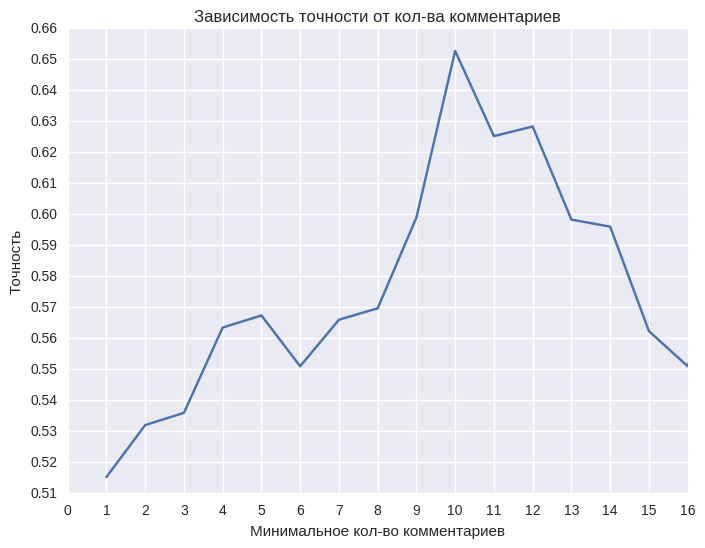

In [115]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(1, 21), x)
# plt.plot(range(3, 21), [x[1] for x in scores])
plt.yticks(np.round(np.linspace(0.51, 0.66, 16), 2));
plt.xticks(np.linspace(0, 16, 17));
plt.ylim(0.51, 0.66)
plt.xlim(0, 16)
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Точность')
plt.title('Зависимость точности от кол-ва комментариев');

In [116]:
fig.savefig('temp.png')

In [126]:
uniq_ids = []
for i in range(1, 17):
    unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= i].index.values
    uniq_ids.append(len(unique_ids))

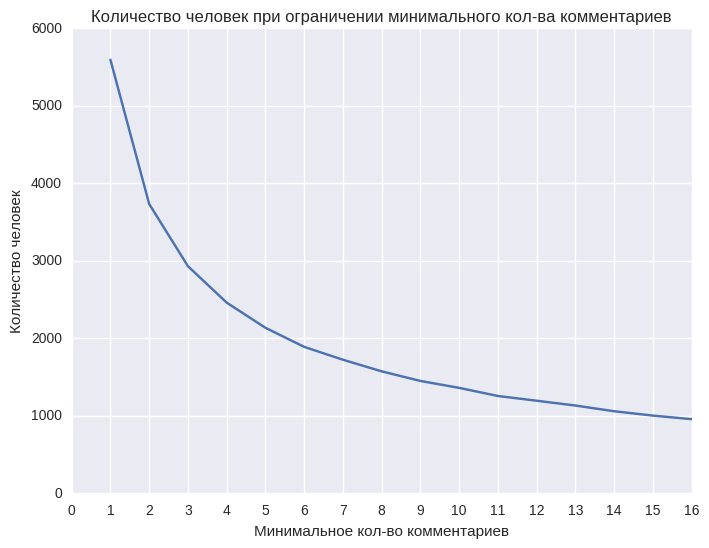

In [129]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, 17), uniq_ids)
plt.xticks(np.linspace(0, 16, 17));
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Количество человек')
plt.title('Количество человек при ограничении минимального кол-ва комментариев');

In [130]:
fig.savefig('temp.png')

In [711]:
with open('unique_ids.pkl', 'wb') as f:
    pickle.dump(unique_ids, f)

In [928]:
with open('unique_ids_10.pkl', 'rb') as f:
    unique_ids = pickle.load(f)

In [785]:
unique_ids = pd.Series(unique_ids).sample(frac=1, random_state=3).values

In [908]:
# unique_ids = pd.Series(unique_ids).sample(frac=1, random_state=3).values
train_idxs = unique_ids[:len(unique_ids) * 0.8]
test_idxs = unique_ids[len(unique_ids) * 0.8:]

train_comments = comments[[i in train_idxs for i in comments.from_id]]
test_comments = comments[[i in test_idxs for i in comments.from_id]]

train_comments.is_gum.value_counts()

0.0    45254
1.0    37810
Name: is_gum, dtype: int64

In [929]:
print(test_comments.is_gum.value_counts())

0.0    9671
1.0    8301
Name: is_gum, dtype: int64


In [910]:
len(train_idxs), len(test_idxs)

(1088, 273)

In [932]:
test_comments.is_gum.value_counts()

0.0    9671
1.0    8301
Name: is_gum, dtype: int64

In [916]:
train_comments.is_gum.value_counts()

1.0    45254
0.0    45254
Name: is_gum, dtype: int64

In [917]:
train_comments.shape, test_comments.shape

((90508, 10), (17972, 10))

In [918]:
X_train = vectorizer.transform(train_comments.text.values)
X_test = vectorizer.transform(test_comments.text.values)

In [919]:
X_test.sum(axis=1)

matrix([[7],
        [1],
        [6],
        ..., 
        [7],
        [2],
        [4]])

In [920]:
lr = lm.LogisticRegression() # class_weight='balanced')

In [921]:
lr.fit(X_train, train_comments.is_gum.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [922]:
lr.score(X_test, test_comments.is_gum.values)

0.52203427553972848

In [923]:
prediction = lr.predict(X_test)

In [924]:
test_comments['prediction'] = prediction

/home/digitman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [926]:
y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
accuracy_score(y_true, y_pred)

0.58608058608058611

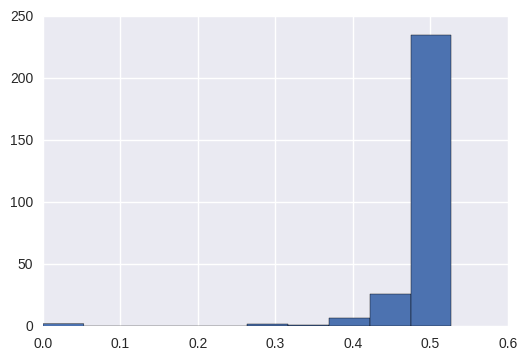

In [904]:
test_comments.groupby('from_id').agg(np.std)['prediction'].hist()

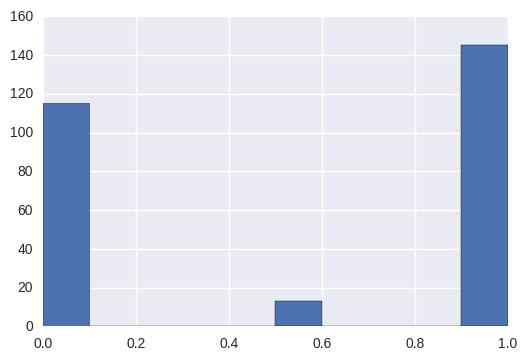

In [905]:
test_comments.groupby('from_id').agg(np.median)['prediction'].hist()